### ETL demonstration
###### Mount to AzureML workspace

In [1]:
from azureml.core import Workspace, Datastore, Dataset
from azure.storage.blob import ContainerClient

subscription_id = '18339a11-8d78-47d7-b204-fc4d2392a1b9'
resource_group = 'M10901K011-rg'
workspace_name = 'PCB-AoI'
workspace = Workspace(subscription_id, resource_group, workspace_name)
datastore = Datastore.get(workspace, "workspaceblobstore")

dataset_path = 'UI/2023-04-23_012149_UTC/train_data'
dataset = Dataset.File.from_files(path=(datastore, dataset_path))
mount = dataset.mount()
mount.start()

###### get `files_path`

In [2]:
image_paths, annot_paths = [], []
with open(mount.mount_point + '/index.txt') as f:
    data = f.readlines()
    for row in data:
        file_name = row.replace('\n','').split(' ')
        image_paths.append(file_name[0][1:])
        annot_paths.append(file_name[1][1:])
image_paths[:2], annot_paths[:2]

(['/JPEGImages/20161019-SPI-AOI-1.jpeg',
  '/JPEGImages/20161020-SPI-AOI-5.jpeg'],
 ['/Annotations/20161019-SPI-AOI-1.xml',
  '/Annotations/20161020-SPI-AOI-5.xml'])

###### define a function that can visualize the sample Annotation

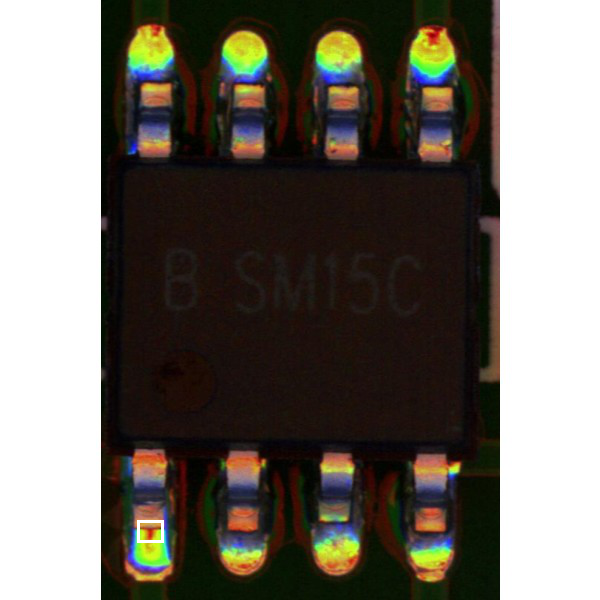

In [3]:
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

def Annotate(image, annotations, true=None):
    annotated_image = image.copy()
    img = ImageDraw.Draw(annotated_image)
    for bounding_box in annotations:
        img.rectangle(bounding_box, outline="white", width=3)
    if true != None:
        img.rectangle(true, outline="red", width=3)
    annotated_image.show()

sample_image = Image.open(mount.mount_point + image_paths[0])
root = ET.parse(mount.mount_point + annot_paths[0]).getroot()
sample_annotations = []
for neighbor in root.iter('bndbox'):
    xmin, ymin, xmax, ymax = int(neighbor.find('xmin').text), int(neighbor.find('ymin').text), int(neighbor.find('xmax').text), int(neighbor.find('ymax').text)
    sample_annotations.append([xmin, ymin, xmax, ymax])

Annotate(sample_image, sample_annotations)

### Modeling
###### Preprocessing

In [4]:
import keras
import numpy as np
image_size = 224
images, targets = [], []
for i in range(0, len(annot_paths)):
    #Image Process
    image = keras.utils.load_img(mount.mount_point + image_paths[i])
    (w, h) = image.size[:2]
    image = image.resize((image_size, image_size))
    images.append(keras.utils.img_to_array(image))
    #Annotation Process
    tree = ET.parse(mount.mount_point + annot_paths[0])
    root = tree.getroot()
    sample_annotations = []
    for neighbor in root.iter('bndbox'):
        xmin, ymin, xmax, ymax = int(neighbor.find('xmin').text), int(neighbor.find('ymin').text), int(neighbor.find('xmax').text), int(neighbor.find('ymax').text)
        sample_annotations.append((float(xmin) / w, float(ymin) / h, float(xmax) / w, float(ymax) / h))
    targets.append(sample_annotations[0])
(x_train), (y_train) = (np.asarray(images[: int(len(images) * 0.8)]), np.asarray(targets[: int(len(targets) * 0.8)]))
(x_test), (y_test) = (np.asarray(images[int(len(images) * 0.8) :]), np.asarray(targets[int(len(targets) * 0.8) :]))
x_train.shape, y_train.shape, x_test.shape, y_test.shape

2023-04-23 07:26:36.078716: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 07:26:37.079661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


((138, 224, 224, 3), (138, 4), (35, 224, 224, 3), (35, 4))

###### Build the ViT model

In [5]:
from tensorflow.keras import layers
import tensorflow as tf
patch_size = 32 

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__()
        self.patch_size = patch_size

    def get_config(self):
        config = super().get_config().copy()
        config.update({"input_shape": input_shape,"patch_size": patch_size,"num_patches": num_patches,"projection_dim": projection_dim,"num_heads": num_heads,"transformer_units": transformer_units,"transformer_layers": transformer_layers,"mlp_head_units": mlp_head_units,})
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images,sizes=[1, self.patch_size, self.patch_size, 1],strides=[1, self.patch_size, self.patch_size, 1],rates=[1, 1, 1, 1],padding="VALID",)
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
    def get_config(self):
        config = super().get_config().copy()
        config.update({"input_shape": input_shape,"patch_size": patch_size,"num_patches": num_patches,"projection_dim": projection_dim,"num_heads": num_heads,"transformer_units": transformer_units,"transformer_layers": transformer_layers,"mlp_head_units": mlp_head_units,})
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def ViT(input_shape,patch_size,num_patches,projection_dim,num_heads,transformer_units,transformer_layers,mlp_head_units):
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    bounding_box = layers.Dense(4)(features)
    return keras.Model(inputs=inputs, outputs=bounding_box)

###### setup hyperparameters and fitting the ViT model

In [6]:
input_shape = (image_size, image_size, 3)
learning_rate = 0.001
batch_size = 32
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 6
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]

model = ViT(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units)
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())
model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=200)

2023-04-23 07:26:41.963557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/200
5/5 [==============================] - 10s 190ms/step - loss: 2.1231
Epoch 2/200
5/5 [==============================] - 1s 188ms/step - loss: 1.3073
Epoch 3/200
5/5 [==============================] - 1s 183ms/step - loss: 0.8276
Epoch 4/200
5/5 [==============================] - 1s 182ms/step - loss: 0.5969
Epoch 5/200
5/5 [==============================] - 1s 182ms/step - loss: 0.5092
Epoch 6/200
5/5 [==============================] - 1s 181ms/step - loss: 0.5043
Epoch 7/200
5/5 [==============================] - 1s 188ms/step - loss: 0.4023
Epoch 8/200
5/5 [==============================] - 1s

###### Evaluation

1/1 [==============================] - 1s 640ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


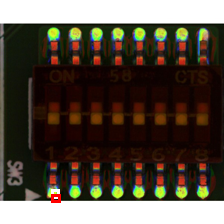

1/1 [==============================] - 0s 47ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


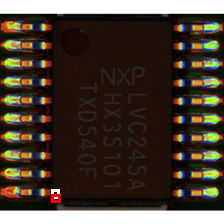

1/1 [==============================] - 0s 45ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


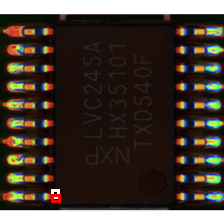

1/1 [==============================] - 0s 45ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


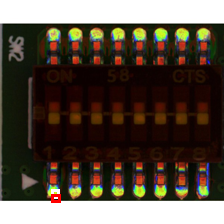

1/1 [==============================] - 0s 46ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


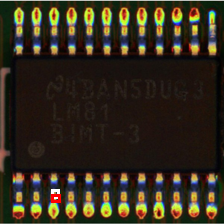

1/1 [==============================] - 0s 45ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


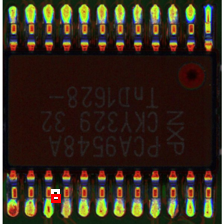

1/1 [==============================] - 0s 48ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


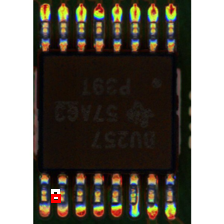

1/1 [==============================] - 0s 45ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


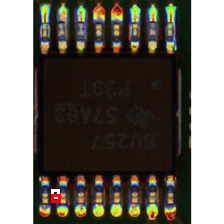

1/1 [==============================] - 0s 43ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


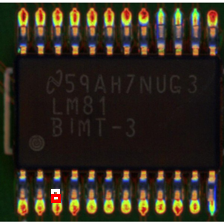

1/1 [==============================] - 0s 47ms/step
Pred: [51, 189, 59, 198]
True: [51, 194, 60, 202]
IoU: 0.3333333333333333


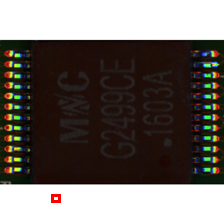

In [7]:
def intersection_over_union(box_predicted, box_truth):
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(0, bottom_y_intersect - top_y_intersect + 1)
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (box_predicted[3] - box_predicted[1] + 1)
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (box_truth[3] - box_truth[1] + 1)
    return intersection_area / float(box_predicted_area + box_truth_area - intersection_area)

for image_true, annot_true in zip(x_test[:10], y_test[:10]):
    annot_pred = model.predict(np.expand_dims(image_true, axis=0))[0]
    pred = [int(annot_pred[0] * image_size), int(annot_pred[1] * image_size), int(annot_pred[2] * image_size), int(annot_pred[3] * image_size)]
    true = [int(annot_true[0] * image_size), int(annot_true[1] * image_size), int(annot_true[2] * image_size), int(annot_true[3] * image_size)]
    print('Pred:', pred)
    print('True:', true)
    print('IoU:', intersection_over_union(pred, true))
    Annotate(tf.keras.utils.array_to_img(image_true), [pred], true)

### Save Model

In [8]:
model.save("PCBAoI_on_ViT.h5")